# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                     
Sample_062  Q8N428                                                15.543
Sample_044  Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6   16.243
Sample_194  O94910;O94910-2                                       17.556
Sample_170  Q8IUK5;Q8IUK5-2;Q8IUK5-3                              15.840
Sample_182  Q9NS85                                                16.143
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups 
Sample_016  Q9Y281;Q9Y281-3   12.180
Sample_131  P00915            17.751
Sample_084  O00241            15.530
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.698
            A0A075B6Q5                 11.606
            A0A075B6R2                 13.068
            A0A075B6S5                 13.623
            A0A087WSY4                 13.272
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.434
            Q9UI40;Q9UI40-2            12.672
            Q9UIW2                     12.425
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.199
            Q9UP79                     12.618
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.949,15.050,16.842,19.863,16.025,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.722,19.067,...,15.528,15.576,14.011,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.866,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.079,17.705,17.039,15.252,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.263,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.350,15.345,17.084,18.708,14.249,19.433,11.254,11.028
Sample_207,15.739,16.877,15.469,16.898,13.028,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,11.698,...,16.012,15.178,12.706,15.050,16.842,19.863,12.769,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.862,19.067,16.188,...,15.528,15.576,11.936,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.926,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.027,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.378,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.919,15.345,17.084,18.708,14.249,19.433,12.183,12.181
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 339.15it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

100%|██████████| 2/2 [00:00<00:00,  4.11it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.58it/s]

100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.58it/s]

100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.02it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.24it/s]

 80%|████████  | 4/5 [00:01<00:00,  1.91it/s]

100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.36it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.63it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.17it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  1.95it/s]

100%|██████████| 6/6 [00:02<00:00,  1.99it/s]

100%|██████████| 6/6 [00:02<00:00,  2.18it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.37it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.58it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.20it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.04it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  1.95it/s]

100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.55it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.06it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.61it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.38it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.26it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.11it/s]

100%|██████████| 8/8 [00:03<00:00,  2.03it/s]

100%|██████████| 8/8 [00:03<00:00,  2.32it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.19it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.91it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.56it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.13it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.93it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.85it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.88it/s]

100%|██████████| 9/9 [00:04<00:00,  2.01it/s]

100%|██████████| 9/9 [00:04<00:00,  2.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.05it/s]

 30%|███       | 3/10 [00:00<00:02,  3.04it/s]

 40%|████      | 4/10 [00:01<00:02,  2.28it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.06it/s]

 60%|██████    | 6/10 [00:02<00:02,  1.97it/s]

 70%|███████   | 7/10 [00:03<00:01,  2.03it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.23it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.42it/s]

100%|██████████| 10/10 [00:04<00:00,  2.51it/s]

100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.55it/s]

 27%|██▋       | 3/11 [00:01<00:02,  2.73it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.10it/s]

 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  1.79it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.93it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.01it/s]

 82%|████████▏ | 9/11 [00:04<00:00,  2.11it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.17it/s]

100%|██████████| 11/11 [00:05<00:00,  2.18it/s]

100%|██████████| 11/11 [00:05<00:00,  2.15it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.05it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.77it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.01it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.91it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.87it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.86it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.07it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  2.06it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.22it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  2.20it/s]

100%|██████████| 12/12 [00:05<00:00,  2.23it/s]

100%|██████████| 12/12 [00:05<00:00,  2.16it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.27it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.47it/s]

 31%|███       | 4/13 [00:01<00:04,  2.04it/s]

 38%|███▊      | 5/13 [00:02<00:04,  1.95it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.92it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.93it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.00it/s]

 69%|██████▉   | 9/13 [00:04<00:01,  2.24it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.33it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.47it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.57it/s]

100%|██████████| 13/13 [00:05<00:00,  2.53it/s]

100%|██████████| 13/13 [00:05<00:00,  2.30it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.47it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.91it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.56it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.47it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.35it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.16it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.07it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.19it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.27it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.28it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.37it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.37it/s]

100%|██████████| 14/14 [00:05<00:00,  2.43it/s]

100%|██████████| 14/14 [00:05<00:00,  2.40it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.55it/s]

 20%|██        | 3/15 [00:00<00:04,  2.88it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.79it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.32it/s]

 40%|████      | 6/15 [00:02<00:04,  2.16it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.01it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.89it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.00it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.14it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.20it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.30it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.38it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.37it/s]

100%|██████████| 15/15 [00:06<00:00,  2.35it/s]

100%|██████████| 15/15 [00:06<00:00,  2.31it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.086 0.040          0.705 0.393       0.098   
2             0.007 0.006      0.068 0.031          0.666 0.100       0.529   
3             0.005 0.005      0.062 0.028          0.758 0.095       0.674   
4             0.006 0.005      0.063 0.029          0.754 0.094       0.712   
5             0.004 0.002      0.055 0.022          0.795 0.083       0.738   
6             0.004 0.003      0.055 0.021          0.811 0.079       0.743   
7             0.005 0.003      0.054 0.020          0.811 0.082       0.747   
8             0.005 0.004      0.057 0.021          0.820 0.083       0.833   
9             0.005 0.004      0.053 0.018          0.823 0.081       0.837   
10            0.005 0.005      0.056 0.020          0.827 0.080       0.831   
11            0.005 0.004      0.052 0.020          0.816 0.086       0.822   
12            0.005 0.003      0.052 0.017          0.813 0.089       0.821   
13            0.005 0.003      0.056 0.022          0.810 0.084       0.819   
14            0.005 0.003      0.057 0.021          0.805 0.083       0.818   
15            0.006 0.005      0.057 0.021          0.820 0.073       0.810   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.078   0.167 0.120                  0.542 0.036        0.850   
2          0.107   0.581 0.077                  0.663 0.052        0.730   
3          0.124   0.707 0.088                  0.756 0.069        0.830   
4          0.131   0.724 0.089                  0.769 0.069        0.842   
5          0.090   0.761 0.066                  0.798 0.053        0.858   
6          0.082   0.772 0.061                  0.807 0.050        0.865   
7          0.089   0.773 0.064                  0.808 0.052        0.863   
8          0.098   0.822 0.065                  0.848 0.056        0.910   
9          0.103   0.825 0.069                  0.851 0.060        0.910   
10         0.103   0.824 0.066                  0.850 0.056        0.909   
11         0.109   0.813 0.073                  0.841 0.062        0.907   
12         0.109   0.812 0.075                  0.840 0.064        0.906   
13         0.103   0.810 0.071                  0.837 0.061        0.904   
14         0.103   0.807 0.072                  0.835 0.062        0.903   
15         0.104   0.810 0.068                  0.839 0.057        0.909   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.823 0.089        210.000 0.000  
2          0.073                  0.669 0.090        210.000 0.000  
3          0.065                  0.807 0.079        210.000 0.000  
4          0.061                  0.826 0.065        210.000 0.000  
5          0.061                  0.846 0.069        210.000 0.000  
6          0.062                  0.846 0.072        210.000 0.000  
7          0.062                  0.844 0.071        210.000 0.000  
8          0.049                  0.899 0.050        210.000 0.000  
9          0.050                  0.900 0.051        210.000 0.000  
10         0.050                  0.896 0.054        210.000 0.000  
11         0.051                  0.894 0.054        210.000 0.000  
12         0.051                  0.894 0.053        210.000 0.000  
13         0.052                  0.890 0.055        210.000 0.000  
14         0.051                  0.888 0.055        210.000 0.000  
15         0.050                  0.891 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 472.92it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.80it/s]

100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  2.99it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.03it/s]

100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.35it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.44it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.05it/s]

100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.09it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.12it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.45it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.06it/s]

100%|██████████| 6/6 [00:02<00:00,  1.94it/s]

100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.14it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.61it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  1.91it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.67it/s]

 86%|████████▌ | 6/7 [00:03<00:00,  1.56it/s]

100%|██████████| 7/7 [00:03<00:00,  1.62it/s]

100%|██████████| 7/7 [00:03<00:00,  1.83it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.30it/s]

 38%|███▊      | 3/8 [00:01<00:02,  1.99it/s]

 50%|█████     | 4/8 [00:02<00:02,  1.63it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.63it/s]

 75%|███████▌  | 6/8 [00:03<00:01,  1.40it/s]

 88%|████████▊ | 7/8 [00:04<00:00,  1.36it/s]

100%|██████████| 8/8 [00:05<00:00,  1.33it/s]

100%|██████████| 8/8 [00:05<00:00,  1.51it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.47it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.22it/s]

 44%|████▍     | 4/9 [00:02<00:03,  1.58it/s]

 56%|█████▌    | 5/9 [00:03<00:02,  1.40it/s]

 67%|██████▋   | 6/9 [00:03<00:02,  1.36it/s]

 78%|███████▊  | 7/9 [00:04<00:01,  1.41it/s]

 89%|████████▉ | 8/9 [00:04<00:00,  1.55it/s]

100%|██████████| 9/9 [00:05<00:00,  1.64it/s]

100%|██████████| 9/9 [00:05<00:00,  1.64it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  2.92it/s]

 30%|███       | 3/10 [00:01<00:03,  1.94it/s]

 40%|████      | 4/10 [00:02<00:03,  1.72it/s]

 50%|█████     | 5/10 [00:02<00:02,  1.75it/s]

 60%|██████    | 6/10 [00:03<00:02,  1.70it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.76it/s]

 80%|████████  | 8/10 [00:04<00:01,  1.72it/s]

 90%|█████████ | 9/10 [00:05<00:00,  1.63it/s]

100%|██████████| 10/10 [00:05<00:00,  1.54it/s]

100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.35it/s]

 27%|██▋       | 3/11 [00:01<00:04,  1.89it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

 45%|████▌     | 5/11 [00:03<00:04,  1.46it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.37it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.43it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

 91%|█████████ | 10/11 [00:05<00:00,  1.85it/s]

100%|██████████| 11/11 [00:06<00:00,  1.94it/s]

100%|██████████| 11/11 [00:06<00:00,  1.71it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.74it/s]

 25%|██▌       | 3/12 [00:00<00:03,  2.94it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.63it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.00it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.72it/s]

 58%|█████▊    | 7/12 [00:03<00:03,  1.65it/s]

 67%|██████▋   | 8/12 [00:04<00:02,  1.69it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.76it/s]

 83%|████████▎ | 10/12 [00:05<00:01,  1.79it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.79it/s]

100%|██████████| 12/12 [00:06<00:00,  1.70it/s]

100%|██████████| 12/12 [00:06<00:00,  1.90it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.34it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.64it/s]

 31%|███       | 4/13 [00:01<00:04,  2.19it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.00it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.94it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.62it/s]

 62%|██████▏   | 8/13 [00:04<00:03,  1.58it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.58it/s]

 77%|███████▋  | 10/13 [00:05<00:02,  1.47it/s]

 85%|████████▍ | 11/13 [00:06<00:01,  1.56it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  1.65it/s]

100%|██████████| 13/13 [00:07<00:00,  1.71it/s]

100%|██████████| 13/13 [00:07<00:00,  1.77it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.43it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.60it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.06it/s]

 36%|███▌      | 5/14 [00:02<00:04,  1.93it/s]

 43%|████▎     | 6/14 [00:02<00:04,  1.92it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.97it/s]

 57%|█████▋    | 8/14 [00:04<00:03,  1.75it/s]

 64%|██████▍   | 9/14 [00:04<00:03,  1.63it/s]

 71%|███████▏  | 10/14 [00:05<00:02,  1.69it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.71it/s]

 86%|████████▌ | 12/14 [00:06<00:01,  1.78it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.89it/s]

100%|██████████| 14/14 [00:07<00:00,  1.93it/s]

100%|██████████| 14/14 [00:07<00:00,  1.92it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.53it/s]

 20%|██        | 3/15 [00:00<00:04,  2.95it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.35it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.04it/s]

 40%|████      | 6/15 [00:02<00:04,  2.00it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.24it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.31it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.39it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.08it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.90it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.74it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.68it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.85it/s]

100%|██████████| 15/15 [00:07<00:00,  1.79it/s]

100%|██████████| 15/15 [00:07<00:00,  2.04it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.075 0.032          0.107 0.279       0.011   
2             0.005 0.004      0.069 0.032          0.690 0.116       0.517   
3             0.005 0.004      0.062 0.027          0.756 0.086       0.725   
4             0.004 0.004      0.053 0.020          0.725 0.080       0.725   
5             0.005 0.004      0.063 0.026          0.795 0.084       0.735   
6             0.005 0.003      0.065 0.027          0.803 0.088       0.736   
7             0.004 0.002      0.055 0.016          0.800 0.089       0.755   
8             0.005 0.003      0.070 0.034          0.823 0.086       0.793   
9             0.006 0.005      0.074 0.031          0.825 0.086       0.782   
10            0.005 0.004      0.060 0.029          0.818 0.087       0.784   
11            0.006 0.005      0.076 0.028          0.845 0.091       0.787   
12            0.005 0.004      0.074 0.034          0.856 0.091       0.796   
13            0.005 0.003      0.059 0.027          0.858 0.079       0.828   
14            0.006 0.005      0.078 0.030          0.860 0.076       0.825   
15            0.006 0.005      0.083 0.043          0.857 0.079       0.821   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.019 0.050                  0.501 0.013        0.871   
2          0.116   0.582 0.094                  0.670 0.061        0.723   
3          0.099   0.736 0.073                  0.776 0.060        0.857   
4          0.103   0.721 0.075                  0.761 0.062        0.856   
5          0.096   0.760 0.074                  0.797 0.060        0.881   
6          0.094   0.764 0.072                  0.801 0.056        0.882   
7          0.102   0.771 0.068                  0.806 0.054        0.890   
8          0.108   0.803 0.074                  0.833 0.061        0.923   
9          0.119   0.797 0.081                  0.829 0.065        0.920   
10         0.116   0.795 0.080                  0.827 0.066        0.919   
11         0.113   0.809 0.080                  0.839 0.064        0.928   
12         0.113   0.819 0.076                  0.847 0.060        0.932   
13         0.106   0.838 0.072                  0.863 0.060        0.939   
14         0.104   0.837 0.067                  0.862 0.055        0.939   
15         0.106   0.834 0.067                  0.859 0.055        0.939   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.057                  0.835 0.086        210.000 0.000  
2          0.067                  0.677 0.092        210.000 0.000  
3          0.053                  0.821 0.068        210.000 0.000  
4          0.056                  0.817 0.072        210.000 0.000  
5          0.054                  0.851 0.076        210.000 0.000  
6          0.053                  0.854 0.072        210.000 0.000  
7          0.051                  0.860 0.070        210.000 0.000  
8          0.045                  0.904 0.056        210.000 0.000  
9          0.046                  0.903 0.056        210.000 0.000  
10         0.046                  0.901 0.055        210.000 0.000  
11         0.044                  0.905 0.057        210.000 0.000  
12         0.043                  0.911 0.056        210.000 0.000  
13         0.039                  0.923 0.048        210.000 0.000  
14         0.039                  0.923 0.048        210.000 0.000  
15         0.039                  0.923 0.048 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 883.20it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 28.03it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 14.93it/s]

100%|██████████| 3/3 [00:00<00:00, 12.30it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 17.31it/s]

100%|██████████| 4/4 [00:00<00:00, 15.41it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 15.59it/s]

100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

100%|██████████| 5/5 [00:00<00:00, 12.77it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 18.33it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.35it/s]

100%|██████████| 6/6 [00:00<00:00, 13.90it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 14.93it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 13.25it/s]

100%|██████████| 7/7 [00:00<00:00, 11.04it/s]

100%|██████████| 7/7 [00:00<00:00, 11.72it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 17.70it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 15.03it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.68it/s]

100%|██████████| 8/8 [00:00<00:00, 13.17it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 14.64it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 11.41it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 10.52it/s]

100%|██████████| 9/9 [00:00<00:00, 10.41it/s]

100%|██████████| 9/9 [00:00<00:00, 10.86it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 15.85it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.15it/s]

 70%|███████   | 7/10 [00:00<00:00, 10.92it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.00it/s]

100%|██████████| 10/10 [00:00<00:00, 11.49it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 15.54it/s]

 45%|████▌     | 5/11 [00:00<00:00, 11.78it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 10.05it/s]

 82%|████████▏ | 9/11 [00:00<00:00,  9.64it/s]

 91%|█████████ | 10/11 [00:01<00:00,  8.74it/s]

100%|██████████| 11/11 [00:01<00:00,  8.68it/s]

100%|██████████| 11/11 [00:01<00:00,  9.61it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 17.93it/s]

 42%|████▏     | 5/12 [00:00<00:00, 11.29it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 10.39it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 10.66it/s]

 92%|█████████▏| 11/12 [00:01<00:00, 10.41it/s]

100%|██████████| 12/12 [00:01<00:00, 10.88it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 16.92it/s]

 38%|███▊      | 5/13 [00:00<00:00, 12.78it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.35it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.84it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 10.00it/s]

100%|██████████| 13/13 [00:01<00:00,  9.35it/s]

100%|██████████| 13/13 [00:01<00:00, 10.57it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 16.27it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.03it/s]

 50%|█████     | 7/14 [00:00<00:00, 11.17it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.18it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.29it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 12.07it/s]

100%|██████████| 14/14 [00:01<00:00, 12.22it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.37it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.19it/s]

 40%|████      | 6/15 [00:00<00:00, 10.88it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 11.18it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 11.37it/s]

 80%|████████  | 12/15 [00:01<00:00, 11.39it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 11.70it/s]

100%|██████████| 15/15 [00:01<00:00, 11.45it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.053 0.018          0.000 0.000       0.000   
2             0.006 0.004      0.066 0.024          0.666 0.114       0.569   
3             0.004 0.003      0.054 0.018          0.700 0.110       0.596   
4             0.005 0.003      0.069 0.025          0.703 0.087       0.627   
5             0.005 0.004      0.057 0.020          0.691 0.090       0.606   
6             0.006 0.006      0.067 0.023          0.686 0.090       0.607   
7             0.005 0.004      0.063 0.025          0.680 0.091       0.591   
8             0.007 0.005      0.066 0.024          0.672 0.100       0.632   
9             0.005 0.003      0.059 0.021          0.681 0.092       0.639   
10            0.004 0.002      0.052 0.015          0.681 0.093       0.647   
11            0.005 0.002      0.049 0.008          0.679 0.090       0.632   
12            0.005 0.003      0.063 0.025          0.677 0.093       0.637   
13            0.006 0.004      0.072 0.028          0.681 0.094       0.635   
14            0.007 0.006      0.070 0.026          0.689 0.088       0.629   
15            0.006 0.005      0.072 0.027          0.692 0.087       0.629   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.764   
2          0.109   0.608 0.093                  0.678 0.070        0.765   
3          0.122   0.637 0.100                  0.703 0.070        0.779   
4          0.119   0.657 0.086                  0.716 0.063        0.791   
5          0.116   0.639 0.083                  0.702 0.060        0.791   
6          0.113   0.638 0.082                  0.701 0.060        0.788   
7          0.112   0.625 0.082                  0.692 0.057        0.790   
8          0.128   0.645 0.097                  0.702 0.074        0.816   
9          0.121   0.652 0.087                  0.708 0.067        0.818   
10         0.118   0.657 0.086                  0.711 0.068        0.815   
11         0.099   0.648 0.070                  0.704 0.056        0.827   
12         0.103   0.649 0.075                  0.704 0.059        0.822   
13         0.103   0.650 0.074                  0.706 0.059        0.823   
14         0.117   0.650 0.083                  0.709 0.063        0.827   
15         0.113   0.652 0.079                  0.710 0.061        0.826   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.702 0.083        210.000 0.000  
2          0.069                  0.718 0.084        210.000 0.000  
3          0.073                  0.722 0.091        210.000 0.000  
4          0.064                  0.746 0.079        210.000 0.000  
5          0.065                  0.750 0.077        210.000 0.000  
6          0.064                  0.744 0.078        210.000 0.000  
7          0.065                  0.750 0.075        210.000 0.000  
8          0.061                  0.770 0.079        210.000 0.000  
9          0.063                  0.771 0.080        210.000 0.000  
10         0.062                  0.767 0.080        210.000 0.000  
11         0.054                  0.780 0.073        210.000 0.000  
12         0.054                  0.775 0.071        210.000 0.000  
13         0.053                  0.774 0.071        210.000 0.000  
14         0.054                  0.778 0.071        210.000 0.000  
15         0.054                  0.777 0.070 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,1,15,14
score_time,1,15,15
test_precision,10,14,4
test_recall,9,13,10
test_f1,9,13,10
test_balanced_accuracy,9,13,4
test_roc_auc,9,13,11
test_average_precision,9,15,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.42it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.91it/s]

 31%|███       | 4/13 [00:01<00:03,  2.31it/s]

 38%|███▊      | 5/13 [00:02<00:04,  1.98it/s]

 46%|████▌     | 6/13 [00:02<00:04,  1.72it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.67it/s]

 62%|██████▏   | 8/13 [00:04<00:02,  1.67it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.72it/s]

 77%|███████▋  | 10/13 [00:05<00:01,  1.77it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.87it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  1.76it/s]

100%|██████████| 13/13 [00:07<00:00,  1.63it/s]

100%|██████████| 13/13 [00:07<00:00,  1.84it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 12.10it/s]

 36%|███▋      | 4/11 [00:00<00:00,  9.45it/s]

 45%|████▌     | 5/11 [00:00<00:00,  9.59it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  9.95it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 10.25it/s]

100%|██████████| 11/11 [00:01<00:00,  9.86it/s]

100%|██████████| 11/11 [00:01<00:00,  9.85it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.78it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.64it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.29it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  1.87it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.73it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.61it/s]

 89%|████████▉ | 8/9 [00:04<00:00,  1.63it/s]

100%|██████████| 9/9 [00:04<00:00,  1.66it/s]

100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


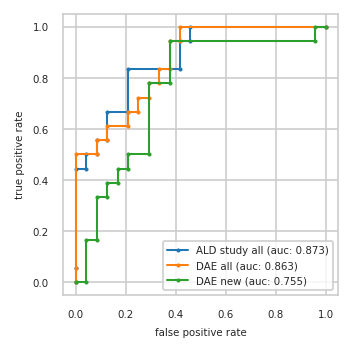

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.444   0.000 0.500   0.042 0.167
3          0.042 0.444   0.083 0.500   0.083 0.167
4          0.042 0.500   0.083 0.556   0.083 0.333
5          0.083 0.500   0.125 0.556   0.125 0.333
6          0.083 0.556   0.125 0.611   0.125 0.389
7          0.125 0.556   0.208 0.611   0.167 0.389
8          0.125 0.667   0.208 0.667   0.167 0.444
9          0.208 0.667   0.250 0.667   0.208 0.444
10         0.208 0.833   0.250 0.722   0.208 0.500
11         0.417 0.833   0.292 0.722   0.292 0.500
12         0.417 0.944   0.292 0.778   0.292 0.778
13         0.458 0.944   0.333 0.778   0.375 0.778
14         0.458 1.000   0.333 0.833   0.375 0.944
15         1.000 1.000   0.375 0.833   0.958 0.944
16           NaN   NaN   0.375 0.944   0.958 1.000
17           NaN   NaN   0.417 0.944   1.000 1.000
18           NaN   NaN   0.417 1.000     NaN   NaN
19           NaN   NaN   1.000 1.000     NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,K7ER15;Q9H0R4;Q9H0R4-2,P02766,Q9UMX0;Q9UMX0-2;Q9UMX0-4
2,P02741,P08670,P51688
3,P61981,P01704,P31321
4,P04075,Q9Y2T3;Q9Y2T3-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P14174,P61981,P42262;P42262-2;P42262-3
6,P05160,Q14894,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
7,P00338;P00338-3,P04075,Q16799
8,Q9Y2T3;Q9Y2T3-3,P14174,O95497


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


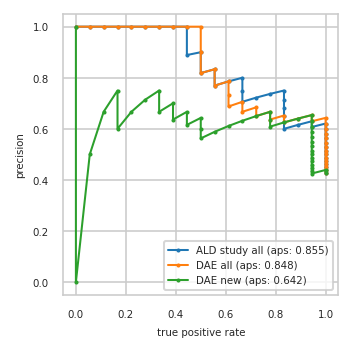

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.425 0.944
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.600 1.000     0.567 0.944
13         0.621 1.000     0.621 1.000     0.586 0.944
14         0.607 0.944     0.643 1.000     0.607 0.944
15         0.630 0.944     0.630 0.944     0.630 0.944
16         0.615 0.889     0.654 0.944     0.654 0.944
17         0.600 0.833     0.640 0.889     0.640 0.889
18         0.625 0.833     0.625 0.833     0.625 0.833
19         0.652 0.833     0.652 0.833     0.609 0.778
20         0.682 0.833     0.636 0.778     0.636 0.778
21         0.714 0.833     0.667 0.778     0.667 0.778
22         0.750 0.833     0.650 0.722     0.650 0.722
23         0.737 0.778     0.684 0.722     0.632 0.667
24         0.722 0.722     0.667 0.667     0.611 0.611
25         0.706 0.667     0.706 0.667     0.588 0.556
26         0.750 0.667     0.688 0.611     0.562 0.500
27         0.800 0.667     0.733 0.611     0.600 0.500
28         0.786 0.611     0.786 0.611     0.643 0.500
29         0.769 0.556     0.769 0.556     0.615 0.444
30         0.833 0.556     0.833 0.556     0.667 0.444
31         0.818 0.500     0.818 0.500     0.636 0.389
32         0.900 0.500     0.900 0.500     0.700 0.389
33         0.889 0.444     1.000 0.500     0.667 0.333
34         1.000 0.444     1.000 0.444     0.750 0.333
35         1.000 0.389     1.000 0.389     0.714 0.278
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


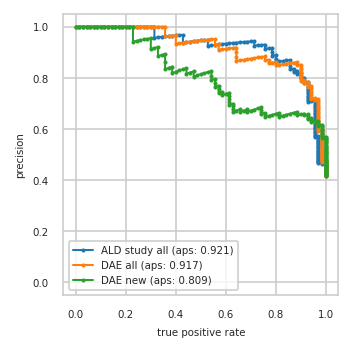

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


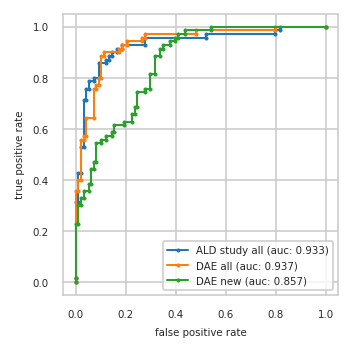

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}